<a href="https://colab.research.google.com/github/VladimirBoshnjakovski/explainable-ai-thesis-code/blob/main/03_whitebox_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ──────────────── DATA HANDLING ────────────────
from google.colab import files       # Enables file upload from local machine in Google Colab
import pandas as pd                  # DataFrame operations and data manipulation

# ──────────────── VISUALIZATION ────────────────
import matplotlib.pyplot as plt      # Basic plotting (line, bar, scatter, etc.)
import seaborn as sns                # Statistical data visualization (heatmaps, boxplots, etc.)

# ──────────────── MODELING AND EVALUATION ────────────────
from sklearn.tree import DecisionTreeClassifier             # Decision Tree classifier
from sklearn.model_selection import train_test_split        # Train-test split utility
from sklearn.metrics import (                               # Evaluation metrics for classification tasks
    classification_report,
    accuracy_score,
    confusion_matrix
)

In [2]:
# ──────────────── LOAD DATASET FROM LOCAL FILE (Colab Upload) ────────────────
uploaded = files.upload()  # Opens file picker to upload from your computer
df = pd.read_csv(next(iter(uploaded)))  # Loads the first uploaded file into a DataFrame

Saving encoded_heart_disease_data.csv to encoded_heart_disease_data.csv


/tmp/ipython-input-1757121354.py:29: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


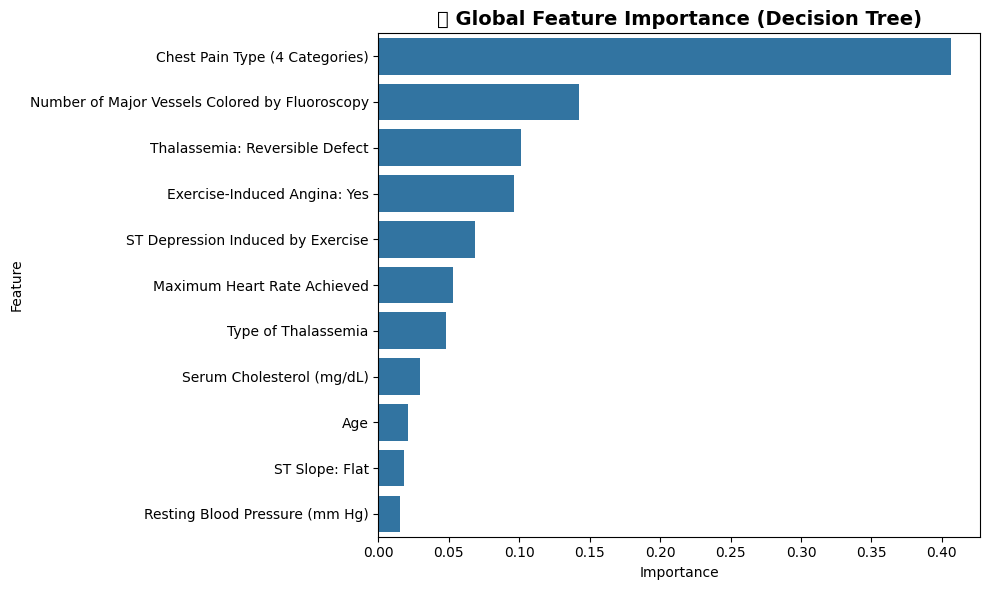

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


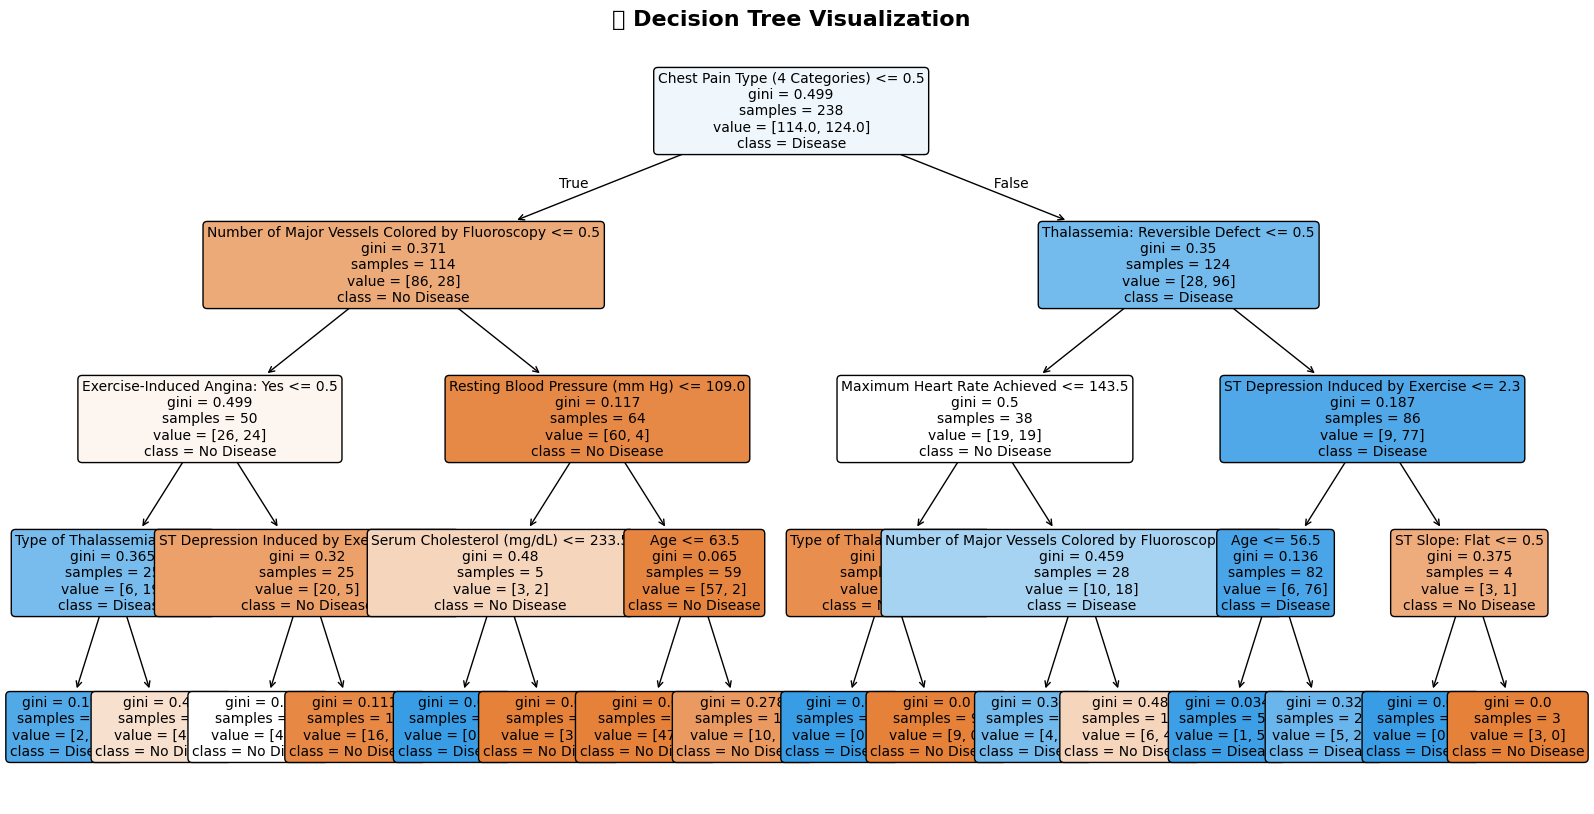


🧪 Instance 1 has both positive and negative contributions:
                                          Feature  Δ Probability for Class 1
0                  Chest Pain Type (4 Categories)                    -0.2754
1  Number of Major Vessels Colored by Fluoroscopy                     0.2344
2                    Exercise-Induced Angina: Yes                    -0.2800
3               ST Depression Induced by Exercise                    -0.1412

✅ Final predicted probability for Class 1: 0.0588


In [7]:
# ──────────────── 1. SPLIT DATA ────────────────
X = df.drop(columns='Presence of Heart Disease (1=Yes)')  # Features
y = df['Presence of Heart Disease (1=Yes)']               # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ──────────────── 2. TRAIN DECISION TREE MODEL ────────────────
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

# ──────────────── 3. GLOBAL FEATURE IMPORTANCE ────────────────
# Extract and sort non-zero feature importances
importances = model.feature_importances_
features = X.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})
importance_df = importance_df[importance_df['Importance'] > 0]
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot bar chart of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("🌍 Global Feature Importance (Decision Tree)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ──────────────── 4. VISUALIZE TREE STRUCTURE ────────────────
plt.figure(figsize=(20, 10))
plot_tree(
    model,
    feature_names=X.columns,
    class_names=['No Disease', 'Disease'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("🌳 Decision Tree Visualization", fontsize=16, fontweight='bold')
plt.show()

# ──────────────── 5. LOCAL EXPLANATION FOR A DECISION TREE INSTANCE ────────────────
# Find the first instance in the test set with both positive and negative feature contributions
# to the predicted probability for Class 1 (e.g., heart disease)

for i in range(len(X_test)):
    instance = X_test.iloc[[i]]  # Get a single test instance as a DataFrame
    node_indicator = model.decision_path(instance)  # Nodes traversed for this instance
    nodes = node_indicator.indices
    feature_contributions = []  # Will store each feature’s impact on prediction

    for node_index in nodes[:-1]:  # Exclude the final leaf node
        feature_index = model.tree_.feature[node_index]
        if feature_index == -2:
            continue  # Skip if it's a leaf

        threshold = model.tree_.threshold[node_index]

        # Determine next node based on split direction
        if instance.iloc[0, feature_index] <= threshold:
            next_node = model.tree_.children_left[node_index]
        else:
            next_node = model.tree_.children_right[node_index]

        # Calculate predicted probability of Class 1 before and after this split
        current_proba = model.tree_.value[node_index][0][1] / model.tree_.value[node_index][0].sum()
        next_proba = model.tree_.value[next_node][0][1] / model.tree_.value[next_node][0].sum()
        contrib = next_proba - current_proba

        # Record contribution
        feature_contributions.append((X.columns[feature_index], round(contrib, 4)))

    # Check if we have both positive and negative contributions
    contrib_vals = [x[1] for x in feature_contributions]
    if any(c > 0 for c in contrib_vals) and any(c < 0 for c in contrib_vals):
        # Format output
        local_df = pd.DataFrame(feature_contributions, columns=["Feature", "Δ Probability for Class 1"])

        # Final prediction probability at the leaf node
        final_node = nodes[-1]
        final_proba = model.tree_.value[final_node][0][1] / model.tree_.value[final_node][0].sum()

        # Print the result
        print(f"\n🧪 Instance {i} has both positive and negative contributions:")
        print(local_df)
        print(f"\n✅ Final predicted probability for Class 1: {round(final_proba, 4)}")
        break  # Stop after finding the first such instance

In [4]:
# ──────────────── LOCAL EXPLANATION FOR DECISION TREE ────────────────
# This loop finds the first test instance where features have both positive and negative contributions
# to the predicted probability for Class 1 (heart disease).

for i in range(len(X_test)):
    instance = X_test.iloc[[i]]  # Get a single test instance as a DataFrame
    node_indicator = dt_model.decision_path(instance)  # Get decision path (nodes traversed)
    nodes = node_indicator.indices  # Indices of the nodes visited
    feature_contributions = []      # Store feature-level contributions to probability change

    for node_index in nodes[:-1]:  # Exclude leaf node
        feature_index = dt_model.tree_.feature[node_index]
        if feature_index == -2:
            continue  # Skip if it's a leaf node

        threshold = dt_model.tree_.threshold[node_index]

        # Determine which child node was taken (left or right)
        if instance.iloc[0, feature_index] <= threshold:
            next_node = dt_model.tree_.children_left[node_index]
        else:
            next_node = dt_model.tree_.children_right[node_index]

        # Get predicted probability for Class 1 at current and next node
        current_proba = dt_model.tree_.value[node_index][0][1] / dt_model.tree_.value[node_index][0].sum()
        next_proba = dt_model.tree_.value[next_node][0][1] / dt_model.tree_.value[next_node][0].sum()

        # Contribution = change in predicted probability caused by this split
        contrib = next_proba - current_proba
        feature_contributions.append((X.columns[feature_index], round(contrib, 4)))

    # Extract just the contribution values
    contrib_vals = [x[1] for x in feature_contributions]

    # Only proceed if this instance has both positive and negative contributions
    if any(c > 0 for c in contrib_vals) and any(c < 0 for c in contrib_vals):
        # Build a DataFrame for easy viewing of contributions
        local_df = pd.DataFrame(feature_contributions, columns=["Feature", "Δ Probability for Class 1"])

        # Final predicted probability at the leaf node
        final_node = nodes[-1]
        final_proba = dt_model.tree_.value[final_node][0][1] / dt_model.tree_.value[final_node][0].sum()

        print(f"\n🧪 Instance {i} has both positive and negative contributions:")
        print(local_df)

        print(f"\n✅ Final predicted probability for Class 1: {round(final_proba, 4)}")
        break  # Stop after the first matching instance


NameError: name 'dt_model' is not defined